# [NTDS'18] milestone 3: spectral graph theory
[ntds'18]: https://github.com/mdeff/ntds_2018

[Michaël Defferrard](http://deff.ch), [EPFL LTS2](https://lts2.epfl.ch)

## Students

* Team: `John`
* Students: `<the name of all students in the team>`
* Dataset: `<the dataset you used to complete the milestone>`

## Rules

* Milestones have to be completed by teams. No collaboration between teams is allowed.
* Textual answers shall be short. Typically one to two sentences.
* Code has to be clean.
* You cannot import any other library than we imported.
* When submitting, the notebook is executed and the results are stored. I.e., if you open the notebook again it should show numerical results and plots. We won't be able to execute your notebooks.
* The notebook is re-executed from a blank state before submission. That is to be sure it is reproducible. You can click "Kernel" then "Restart & Run All" in Jupyter.

## Objective

The goal of this milestone is to get familiar with the graph Laplacian and its spectral decomposition.

## 0 Load your network

In [1]:
%matplotlib inline

If you get a `No module named 'sklearn'` error when running the below cell, install [scikit-learn](https://scikit-learn.org) with `conda install scikit-learn` (after activating the `ntds_2018` environment).

In [2]:
import numpy as np
from scipy import sparse
import scipy.sparse.linalg
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

Let's denote your graph as $\mathcal{G} = (\mathcal{V}, \mathcal{E}, A)$, where $\mathcal{V}$ is the set of nodes, $\mathcal{E}$ is the set of edges, $A \in \mathbb{R}^{N \times N}$ is the (weighted) adjacency matrix, and $N = |\mathcal{V}|$ is the number of nodes.

Import the adjacency matrix $A$ that you constructed in the first milestone.
(You're allowed to update it between milestones if you want to.)

In [3]:
A = np.load('adjacency.npy')
# deleting nodes without any connection
zero_index = np.where(np.sum(A, axis=0) == 0)[0]
A = np.delete(A, zero_index, axis = 0)
A = np.delete(A, zero_index, axis = 1)

n_nodes =  A.shape[0]
n_edges =  np.count_nonzero(A) / 2

print('Number of nodes = {n:}'.format(n=n_nodes))
print('Number of edges = {e:}'.format(e=n_edges))

Number of nodes = 848
Number of edges = 8196.0


## 1 Graph Laplacian

### Question 1

From the (weighted) adjacency matrix $A$, compute both the combinatorial (also called unnormalized) and the normalized graph Laplacian matrices.

Note: if your graph is weighted, use the weighted adjacency matrix. If not, use the binary adjacency matrix.

For efficient storage and computation, store these sparse matrices in a [compressed sparse row (CSR) format](https://en.wikipedia.org/wiki/Sparse_matrix#Compressed_sparse_row_.28CSR.2C_CRS_or_Yale_format.29).

In [4]:
# degree matrix
D = np.diag(A.sum(axis=1))

laplacian_combinatorial =  D - A
laplacian_normalized = scipy.linalg.fractional_matrix_power(D,-0.5) @ laplacian_combinatorial @ scipy.linalg.fractional_matrix_power(D,-0.5)

Use one of them as the graph Laplacian $L$ for the rest of the milestone.
We however encourage you to run the code with both to get a sense of the difference!

In [5]:
laplacian = laplacian_normalized
#laplacian = laplacian_combinatorial

### Question 2

Compute the eigendecomposition of the Laplacian $L = U^\top \Lambda U$, where the columns $u_k \in \mathbb{R}^N$ of $U = [u_1, \dots, u_N] \in \mathbb{R}^{N \times N}$ are the eigenvectors and the diagonal elements $\lambda_k = \Lambda_{kk}$ are the corresponding eigenvalues.

Make sure that the eigenvalues are ordered, i.e., $0 = \lambda_1 \leq \lambda_2 \leq \dots \leq \lambda_N$.

In [6]:
# normalized laplacian
eigenvalues, eigenvectors =  scipy.linalg.eigh(laplacian)

# unnormalized laplacian
eigenvalues_un, eigenvectors_un =  scipy.linalg.eigh(laplacian_combinatorial)

# sort eigenvalues in increasing order
idx = eigenvalues.argsort()
eigenvalues = np.real(eigenvalues[idx])
eigenvectors = np.real(eigenvectors[:,idx])

idx = eigenvalues_un.argsort()
eigenvalues_un = np.real(eigenvalues_un[idx])
eigenvectors_un = np.real(eigenvectors_un[:,idx])

assert eigenvectors.shape == (n_nodes, n_nodes)
assert eigenvectors_un.shape == (n_nodes, n_nodes)

Justify your choice of eigensolver.

**Answer:**
We use $scipy.linalg.eigh$ to solve for the eigenvalues and eigenvectors. This produces the same results as the counterpart in the numpy library. The $eigh$ function deals with real, symmetric matrix (which is the case in our project) whereas $eig$ function only deals square matrices in general. Therefore, using scipy.linalg.eigh would produce more accurate results.

### Question 3

We can write $L = S S^\top$. What is the matrix $S$? What does $S^\top x$, with $x \in \mathbb{R}^N$, compute?

**Answer:**
The matrix $S$ is the incidence matrix whose dimensions are $N$ (n_nodes) by $E$ (n_edges) and is therefore rectangular in general. $S(i,j)$ = +1 if the edge $j$ connects node $i$ to some other node $k$. Conversely, $S(k,j)$ = -1 since the edge $j$ connects node $i$ to $k$. The incidence matrix therefore has a sense of directionality. All other entries are zero. 

Following the same logic, this means that each column of $S$ contains exactly one +1 and -1. Thus, $S^\top x$ is the gradient vector of $x$ , and computes the gradient (difference) between exactly two values (e.g. signal functions of nodes) within the vector $x$ between which there exists an edge.

### Question 4

Show that $\lambda_k = \| S^\top u_k \|_2^2$, where $\| \cdot \|_2^2$ denotes the squared Euclidean norm (a.k.a. squared $L^2$ norm).

**Answer:**
$\| S^\top u_k \|_2^2$
= $u_k^\top S S^\top u_k$
= $u_k^\top L u_k$
= $u_k^\top \lambda_k u_k$
= $\lambda_k u_k^\top u_k$
= $\lambda_k$

What does the quantity $\| S^\top x \|_2^2$ tell us about $x$?

**Answer:**
Since $S^\top x$ produces the gradient vector of $x$, $\| S^\top x \|_2^2$ computes the sum of all gradients (differences) between each pair of values of nodes between which there exists an edge. 

### Question 5

What is the value of $u_0$, both for the combinatorial and normalized Laplacians?

**Answer:**
In theory, the eigenvector corresponding to eigenvalue 0, $u_0$, is an indicator vector of all 1's. If the multiplicity of eigenvalue 0 is 1, then the elements of the eigenvector will be all 1's. Otherwise, there will be as many indictor vectors as the multiplicity, which indicates the number of disconnected components. Different indicator vectors will be mutually exclusive in the sense that a node whose value is 1 in one indicator vector will be 0 in all other indicator vectors.

### Question 6

Look at the spectrum of the Laplacian by plotting the eigenvalues.
Comment on what you observe.

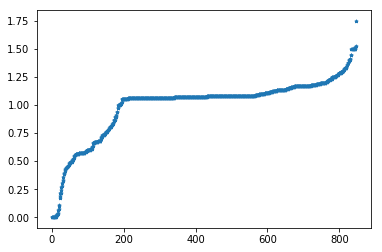

In [7]:
x = range(len(eigenvalues))
plt.scatter(x, eigenvalues, marker='*', s=10)

**Answer:**
There appears to be several eigenvalues very close to 0, possibly indicating that our network is composed of several disconnected components. Moreover, there appears to be a relatively large gap early in the spectrum (roughly between 22nd and 23rd) eigenvalues which may hint at an appropriate value of $k$ to use in spectral clustering. Additionally, the eigenvalue appears to increase more or less steadily until about the 200th eigenvalue, after which the magnitude of the subsequent eigenvalues are in an apparent plateau (or very small increase in magnitude). Finally, towards the end, the later eigenvalues increase exponentially.

How many connected components are there in your graph? Answer using the eigenvalues only.

In [8]:
# choose an arbitrarily small number very close to 0
num_components = sum(eigenvalues < 0.0000000001)

# Add back the three (3) isolated nodes that we removed in the very beginning
print("Number of disconnected components: {n:}".format(n=num_components + 3))

Number of disconnected components: 13


In [9]:
max(eigenvalues)

1.7481659383009864

Is there an upper bound on the eigenvalues, i.e., what is the largest possible eigenvalue? Answer for both the combinatorial and normalized Laplacians.

**Answer:**
The maximum value for unnormalized laplacian is 37.71 while that for normalized laplacian is approximately 1.748. In general, for a simple graph such as our network, the largest eigenvalue cannot be greater than the maximum of the combined degrees of any pair of nodes between which an edge exists. That is, $\lambda_\max$ $\leq$ $max \{d(u) + d(v) | (u, v)$ $\in$ $E(G)\}$ [1].

[1] https://arxiv.org/pdf/1111.2897.pdf

## 3 Laplacian eigenmaps

*Laplacian eigenmaps* is a method to embed a graph $\mathcal{G}$ in a $d$-dimensional Euclidean space.
That is, it associates a vector $z_i \in \mathbb{R}^d$ to every node $v_i \in \mathcal{V}$.
The graph $\mathcal{G}$ is thus embedded as $Z \in \mathbb{R}^{N \times d}$.

### Question 7

What do we use Laplacian eigenmaps for? (Or more generally, graph embeddings.)

**Your answer here.**

### Question 8

Embed your graph in $d=2$ dimensions with Laplacian eigenmaps.
Try with and without re-normalizing the eigenvectors by the degrees, then keep the one your prefer.

**Recompute** the eigenvectors you need with a partial eigendecomposition method for sparse matrices.
When $k \ll N$ eigenvectors are needed, partial eigendecompositions are much more efficient than complete eigendecompositions.
A partial eigendecomposition scales as $\Omega(k |\mathcal{E}|$), while a complete eigendecomposition costs $\mathcal{O}(N^3)$ operations.

In [10]:
# Your code here.

Plot the nodes embedded in 2D. Comment on what you see.

In [11]:
# Your code here.

**Your answer here.**

### Question 9

What does the embedding $Z \in \mathbb{R}^{N \times d}$ preserve?

**Your answer here.**

## 2 Spectral clustering

*Spectral clustering* is a method to partition a graph into distinct clusters.
The method associates a feature vector $z_i \in \mathbb{R}^d$ to every node $v_i \in \mathcal{V}$, then runs [$k$-means](https://en.wikipedia.org/wiki/K-means_clustering) in the embedding space $\mathbb{R}^d$ to assign each node $v_i \in \mathcal{V}$ to a cluster $c_j \in \mathcal{C}$, where $k = |\mathcal{C}|$ is the number of desired clusters.

### Question 10

Choose $k$ and $d$. How did you get to those numbers?

**Answer:**
We choose $k$ = 4 because the nodes of our network have one (or more) of four labels -- colleague, congregate, contact, and family.

The value of $d$ is determined by observing the laplacian spectrum. We look for a gap, or relatively large increase, in the laplacian spectrum, a technique formally known as "eigengap heuristic". Applying this concept we can see below that there is a relatively large gap between the $22^{nd}$ and $23^{rd}$ eigenvalues (with values 0.1077 and 0.1737 respectively). Therefore we choose $d = 21$. However, because the first 10 eigenvectors are 'trivial' (corresponding to eigenvalue 0), we use $11^{th}$ eigenvectors to the $22^{nd}$.

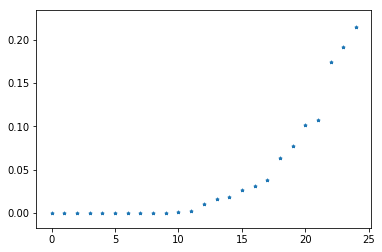

In [12]:
plt.scatter(x[:25], eigenvalues[:25], marker='*', s=10)

### Question 11

1. Embed your graph in $\mathbb{R}^d$ as $Z \in \mathbb{R}^{N \times d}$.
   Try with and without re-normalizing the eigenvectors by the degrees, then keep the one your prefer.
1. If you want $k=2$ clusters, partition with the Fiedler vector. For $k > 2$ clusters, run $k$-means on $Z$. Don't implement $k$-means, use the `KMeans` class imported from scikit-learn.

(array([274.,  28.,  21., 110., 119.,   3., 118.,  22.,  65.,   3.,   9.,
         39.,   3.,   3.,   3.,  28.]),
 array([ 0.    ,  0.9375,  1.875 ,  2.8125,  3.75  ,  4.6875,  5.625 ,
         6.5625,  7.5   ,  8.4375,  9.375 , 10.3125, 11.25  , 12.1875,
        13.125 , 14.0625, 15.    ]),
 <a list of 16 Patch objects>)

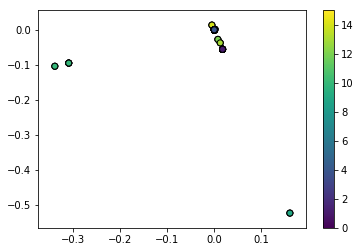

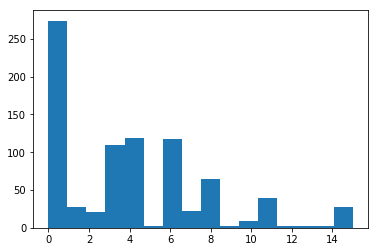

In [85]:
# number of clusters
k = 16

# create Kmeans object
clusters = KMeans(k)
Z = eigenvectors[:,:21]
clusters.fit(Z)
labels = clusters.labels_

# 2D scatter plot
plt.scatter(Z[:,0], Z[:,1], c=labels.astype(np.float), edgecolor='k')
plt.colorbar()
plt.figure()

# Histogram of cluster assignments
plt.hist(labels, bins=16)

### Question 12

Use the computed cluster assignment to reorder the adjacency matrix $A$.
What do you expect? What do you observe?

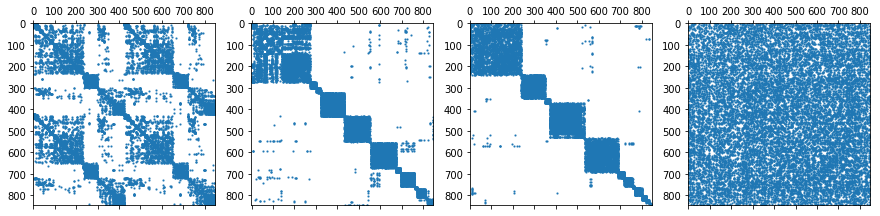

In [86]:
# Sort of the columns according to labels starting with cluster 0
idx = labels.argsort()
adj_sorted = A[:,idx]
adj_sorted = adj_sorted[idx,:]

# plot original adjacency
fig = plt.figure(figsize=(15,4))
ax1 = fig.add_subplot(141)
ax1.spy(A,markersize=1)

# plot rearranged adjacency according to cluster assignments
ax2 = fig.add_subplot(142)
ax2.spy(adj_sorted, markersize=1)

# based on unnormalized laplacian
clusters = KMeans(k)
Z_un = eigenvectors_un[:,:21]
clusters.fit(Z_un)
labels_un = clusters.labels_
idx2 = labels_un.argsort()
adj_sorted_un = A[:,idx2]
adj_sorted_un = adj_sorted_un[idx2,:]
ax3 = fig.add_subplot(143)
ax3.spy(adj_sorted_un,markersize=1)

# random permutation for comparison 
idx3 = np.random.permutation(list(range(n_nodes)))
temp = A[:,idx3]
temp = temp[idx3,:]
ax4 = fig.add_subplot(144)
ax4.spy(temp,markersize=1)

**Answer:**
From the left, we have the original adjacency matrix, the reordered adjacency matrices based on normalized and unnormalized laplacians respectively, and finally an adjacency formed by random permutation for comparison purposes. Because the original adjacency matrix is somewhat "block-diagonal", we expect that the reordered adjacency matrices will preserve this pattern by having similarly sized clusters represented in a similar pattern.

We see that the adjacency matrix based on normalized laplacian (second from the left) does the best job in emulating this property. Though it is not perfectly block-diagonal, it develops similarly sized clusters. The random permutation only helps to show that the generated clusters are indeed non-random.

### Question 13

If you have ground truth clusters for your dataset, compare the cluster assignment from spectral clustering to the ground truth.
A simple quantitative measure is to compute the percentage of nodes that have been correctly categorized.
If you don't have a ground truth, qualitatively assess the quality of the clustering.

Ground truth clusters are the "real clusters".
For example, the genre of musical tracks in FMA, the category of Wikipedia articles, the spammer status of individuals, etc.
Look for the `labels` in the [dataset descriptions](https://github.com/mdeff/ntds_2018/tree/master/projects/README.md).

In [15]:
# Your code here.

### Question 14

Plot the cluster assignment (one color per cluster) on the 2D embedding you computed above with Laplacian eigenmaps.

In [16]:
# 2D scatter plot with color coding according to cluster assignment

### Question 15

Why did we use the eigenvectors of the graph Laplacian as features? Could we use other features for clustering?

**Answer:**
lecture notes on using rows as features